In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# resnet_autoencoder/
# │
# ├── data/                  # Downloaded datasets
# ├── models/
# │   ├── encoder.py
# │   ├── decoder.py
# │   └── autoencoder.py
# ├── train.py               # Training script
# ├── visualize.py           # Plot original vs reconstructed
# └── requirements.txt       # torch, torchvision, matplotlib, etc.


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust to ResNet input
    transforms.ToTensor()
])

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [ ]:
import torchvision.models as models
import torch.nn as nn

class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]  # Keep layers before avgpool
        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)  # Output shape: [B, C, H, W]


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # Assuming encoder output is [B, 512, 4, 4] for 128x128 input
            # Transpose Conv 1: 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Transpose Conv 2: 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Transpose Conv 3: 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Transpose Conv 4: 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Transpose Conv 5: 64x64 -> 128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # Output values are between 0 and 1
        )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = ResNetEncoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
import torch
import torch.nn as nn

# Assuming AutoEncoder class is defined as in the previous cells

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Change "cuda" to "cpu" if you want to run on CPU
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Using device: cuda


100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]


In [ ]:
# Train model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        # Move images to the determined device
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.01717309073111533
Epoch 2, Loss: 0.006595973837096482
Epoch 3, Loss: 0.004761919254780082
Epoch 4, Loss: 0.0037232097544971747
Epoch 5, Loss: 0.003133807748155978
Epoch 6, Loss: 0.002743543232576755
Epoch 7, Loss: 0.0024532172778297377
Epoch 8, Loss: 0.002257849262489001
Epoch 9, Loss: 0.0020482672163752167
Epoch 10, Loss: 0.001880030512161877


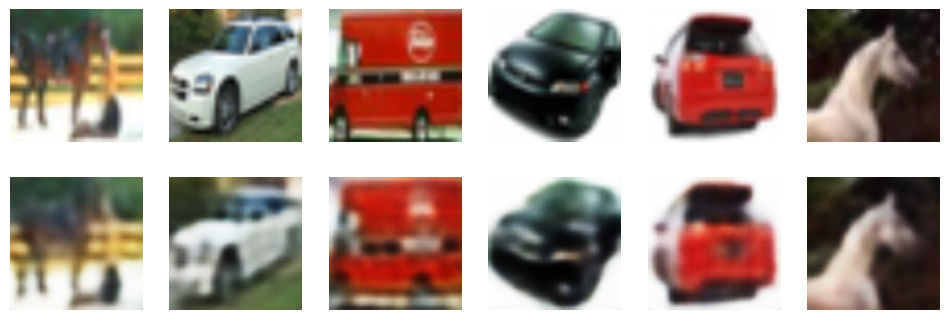

In [ ]:
# Evaluate the Reconstruction
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, _ = next(iter(train_loader))
    images = images.to("cuda")
    outputs = model(images)
    images = images.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[1, i].imshow(outputs[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.show()
